In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from keras.layers import Conv2D, Activation, BatchNormalization
from keras.layers import UpSampling2D, Input, Concatenate
from keras.models import Model
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import Recall, Precision
from keras import backend as K

In [ ]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.12.0


In [ ]:
def image_augmentation(x, y):
    """Returns (maybe) augmented images

    (1) Random flip (left <--> right)
    (2) Random flip (up <--> down)
    (3) Random brightness
    (4) Random hue

    Args:
        image (3-D Tensor): Image tensor of (H, W, C)
        mask (3-D Tensor): Mask image tensor of (H, W, 1)

    Returns:
        image: Maybe augmented image (same shape as input `image`)
        mask: Maybe augmented mask (same shape as input `mask`)
    """
    concat_image = tf.concat([x,y], axis=-1)

    maybe_flipped = tf.image.random_flip_left_right(concat_image)
    maybe_flipped = tf.image.random_flip_up_down(concat_image)

    # sheared = tf.keras.preprocessing.image.random_shear(maybe_flipped, 20,
    #                                         row_axis=0, col_axis=1,
    #                                         channel_axis=2)

    x = maybe_flipped[:, :, :3]
    y = maybe_flipped[:, :, 3:]

    x = tf.image.random_brightness(x, 0.7)
    x = tf.image.random_hue(x, 0.3)
   

    return x, y

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
IMAGE_SIZE = 512
EPOCHS = 60
BATCH = 8
LR = 1e-4

PATH = "/content/drive/MyDrive/"

In [ ]:
def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "patches/*")))
    masks = sorted(glob(os.path.join(path, "labels/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    #test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    #train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    #train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)

In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print(valid_x,valid_y)

Training data:  6784
Validation data:  1695
['/content/drive/MyDrive/patches/IDRiD_05_p49.jpeg', '/content/drive/MyDrive/patches/IDRiD_47_p17.jpeg', '/content/drive/MyDrive/patches/IDRiD_23_p50.jpeg', '/content/drive/MyDrive/patches/IDRiD_02_p145.jpeg', '/content/drive/MyDrive/patches/IDRiD_45_p48.jpeg', '/content/drive/MyDrive/patches/IDRiD_42_p42.jpeg', '/content/drive/MyDrive/patches/IDRiD_42_p100.jpeg', '/content/drive/MyDrive/patches/IDRiD_03_p134.jpeg', '/content/drive/MyDrive/patches/IDRiD_36_p153.jpeg', '/content/drive/MyDrive/patches/IDRiD_09_p58.jpeg', '/content/drive/MyDrive/patches/IDRiD_17_p38.jpeg', '/content/drive/MyDrive/patches/IDRiD_28_p96.jpeg', '/content/drive/MyDrive/patches/IDRiD_03_p128.jpeg', '/content/drive/MyDrive/patches/IDRiD_11_p65.jpeg', '/content/drive/MyDrive/patches/IDRiD_13_p3.jpeg', '/content/drive/MyDrive/patches/IDRiD_34_p10.jpeg', '/content/drive/MyDrive/patches/IDRiD_38_p58.jpeg', '/content/drive/MyDrive/patches/IDRiD_13_p8.jpeg', '/content/drive/

In [ ]:
def read_image(path):
    path = path.decode()
    #print("mmmm",path)
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    
    path = path.decode()
    #print(path)
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
def tf_parse(x, y):
   
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    
    return x, y

def tf_dataset(x, y, batch=8,augmentation=True,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
       dataset = dataset.shuffle(buffer_size=14000)
    
    dataset = dataset.map(tf_parse)
    if augmentation:
       dataset = dataset.map(image_augmentation)
    dataset = dataset.batch(batch)
    
   
    dataset = dataset.repeat()
    return dataset

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH,augmentation=False,shuffle=False)
print(valid_dataset)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float64, name=None))>


In [ ]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=1)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
        
    f = [64,128,256,512]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    # for layer in  encoder.layers:
    #     layer.trainable = False
    return model

In [ ]:
model = model()
model.summary()

In [ ]:
def BCE(y_pred, y_true):
    # weight ratio = 9:1
    # 9-1=8
    class_weights = tf.constant([8],dtype=tf.float32)
    tensor_one = tf.constant([1],dtype=tf.float32)

    pred_flat = tf.reshape(y_pred, [-1, 1])
    true_flat = tf.reshape(y_true, [-1, 1])

    weight_map = tf.multiply(true_flat, class_weights)
    weight_map = tf.add(weight_map, tensor_one)

    loss_map = tf.nn.sigmoid_cross_entropy_with_logits(logits=pred_flat, labels=true_flat)
    loss_map = tf.multiply(loss_map, weight_map)
    loss = tf.reduce_mean(loss_map)
    return loss

In [ ]:
def IOU(y_pred, y_true):
    """Returns a (approx) IOU score

    intesection = y_pred.flatten() * y_true.flatten()
    Then, IOU = 2 * intersection / (y_pred.sum() + y_true.sum() + 1e-7) + 1e-7

    Args:
        y_pred (4-D array): (N, H, W, 1)
        y_true (4-D array): (N, H, W, 1)

    Returns:
        float: IOU score
    """
    H, W, _ = y_pred.get_shape().as_list()[1:]

    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])

    intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1) + 1e-7
    denominator = tf.reduce_sum(
        pred_flat, axis=1) + tf.reduce_sum(
            true_flat, axis=1) + 1e-7

    return tf.reduce_mean(intersection / denominator)

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
optimizer = tf.optimizers.Adam(LR, beta_1=0.9, beta_2=0.999)
metrics = [dice_coef,IOU,Recall(), Precision()]

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/hemo/model_2.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=False)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    #EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    checkpoint_callback
]

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

print(train_steps,valid_steps)

848 212


In [ ]:
history=model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)


Epoch 1/32
 56/848 [>.............................] - ETA: 27:49:18 - loss: 0.0251 - dice_coef: 0.2284 - IOU: 0.0799 - recall: 0.3771 - precision: 0.7777

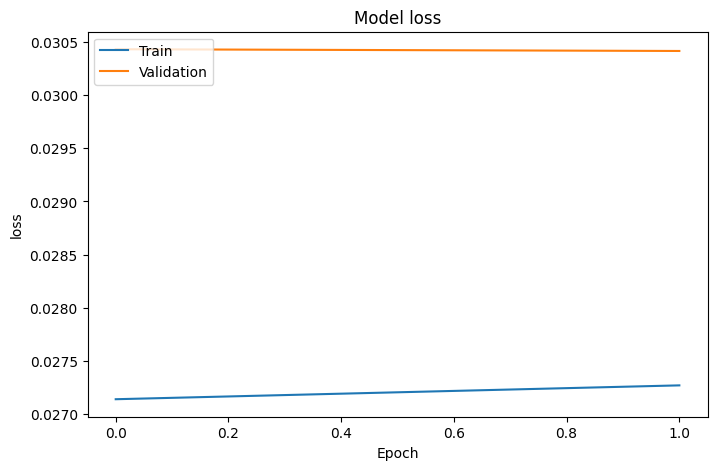

In [ ]:
plt.figure(figsize=(8,5))
#plt.plot(history.epoch, history.loss, label="loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/model_1.h5' , custom_objects={"IOU": IOU,"dice_coef":dice_coef})

In [ ]:
test_x = sorted(glob(os.path.join(PATH, "data_test/*")))
test_y = sorted(glob(os.path.join(PATH, "gt_test/*")))
test_dataset = tf_dataset(test_x, test_y, batch=BATCH,augmentation=False,shuffle=False)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

4/4 [==============================] - 36s 7s/step - loss: 0.0546 - IOU: 0.0498 - recall: 0.0124 - precision: 0.0960


[0.054634902626276016,
 0.04982246458530426,
 0.012371504679322243,
 0.09598725289106369]

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

test the whole image

In [ ]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

test patches of the image

In [ ]:
for i, (x, y) in enumerate(zip(test_x[6:7], test_y[6:7])):
    x = read_image(x)
    y = read_mask(y)
    predicted_image = np.zeros((2848, 4288), dtype=float)
    for i in range(10):
          for j in range(16):
            top_y = i*256
            if (i==9):
              top_y = 2336
            top_x = j*256
            if (j==15):
              top_x = 3776

            image_crop = x[top_y:top_y+512, top_x:top_x+512]
            predicted_crop = model.predict(np.expand_dims(image_crop, axis=0))[0]
            predicted_crop =np.squeeze(predicted_crop)
            predicted_image[top_y:top_y+512, top_x:top_x+512] = np.maximum(predicted_image[top_y:top_y+512, top_x:top_x+512], predicted_crop)
           
    threshold = 0.5
    predicted_image = predicted_image > threshold
    # predicted_image= cv2.resize(predicted_image, (IMAGE_SIZE, IMAGE_SIZE))
    # x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))
    
    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(predicted_image)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    
    # fig = plt.figure(figsize=(12, 12))
    # fig.add_subplot(1, 3, 1)
    # plt.imshow(x)

    # fig.add_subplot(1, 3, 2)
    # plt.imshow(mask_parse(y))
    # fig.add_subplot(1, 3, 3)
    # plt.imshow(mask_parse(predicted_image))

    break